# Classification and Regression with a Neural Network in Pytorch

Welcome to your first programming assignment! 
In this assignment you will build your first classification and regression neural networks.
This assignment is a 'step-through' guide to implement a simple fully-connected neural network in Pytorch.

* In the first part of this exercise, you will implement a neural network with a 2 dimensional input. Your dataset is based on a two <a href=https://en.wikipedia.org/wiki/Crescent> crescent </a> moon-shaped groups for classification.

* Then, in the second part of this exercise, you will implement a regression model for predicting the output of a two dimensional function.

# Packages
Let's first import all the packages that you will need during this part of assignment.

Feel free to use another libraries if you want to.

In [2]:
import numpy as np
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
import pdb
from tqdm import tqdm

# Dataset

In [3]:
id_num_str = input("Please Enter your Israeli ID?")
if (len(id_num_str) != 9):
    print('ID should contain 9 digits')
if (id_num_str.isdigit() is False):
    print('ID should contain only digits')
id_num = list(id_num_str[-3:])
random_num = sum(list(map(int, id_num)))
random_num

9

In [ ]:
np.random.seed(random_num)
torch.manual_seed(random_num)
x, y = make_moons(500, noise=0.2, random_state = random_num)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=random_num)

**Visualize the dataset using matplotlib:**

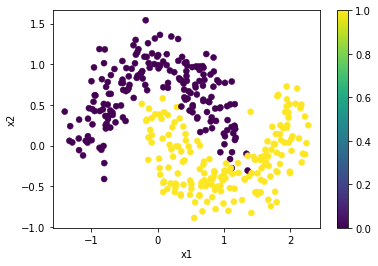

In [7]:
### START CODE HERE ###
#2 dimensional graph: purple points - class 0 , yellow points - class1
zline = y_train
xline = x_train[:,0]
yline = x_train[:,1]
plt.scatter(xline,yline,c=zline,cmap='viridis',linewidth=0.5)
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar()
plt.show()


# Simple Logistic Regression

What you are required to do:

1. Implement a 2-class classification neural network with a zero hidden layer.
2. Plot loss vs epoch.
3. Plot AUC vs epoch for train and test sets. 
4. Plot ROC curve and calculate AUC for the test set.
5. Plot the learned decision boundary.
6. Briefly interpret graph's results.   

How you will do it:

1. Prepare the Data.
2. Define the Model.
3. Train the Model.
4. Evaluate the Model.
5. Visualization.

In [6]:
### START CODE HERE ###
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)
#x_train = x_train.double()

**Define the Model:**

In [9]:


class MlpArgs():
    def __init__(self,lr,num_epochs):
        self.lr = lr
        self.num_epochs = num_epochs

class MlpLogisticClassifier(nn.Module):
    def __init__(self, in_features):
        super(MlpLogisticClassifier, self).__init__()
        self.linear = torch.nn.Linear(in_features, 1)

    def forward(self, x):
        x = x.float()
        x = F.sigmoid(self.linear(x))
        return x

#infer function
def infer(net, data,criterion):
    net.eval()
    running_loss = 0
    for i in range(len(data[0])):
        x = data[0][i]
        y = data[1][i]
        with torch.no_grad():
            pred = net(x)
            loss = criterion(y, pred).item()
        running_loss += loss
    return running_loss / len(data)

def training_loop(
    args,
    net,
    train,
    validation=None,
    test=None,
    criterion_func=nn.MSELoss,
    optimizer_func=torch.optim.SGD,
):
    """The training runs here.
    args: a class instance that contains the arguments
    net: the network we're training
    tr_loader, val_loader, test_loader: dataloaders for the train, validation and test sets
    criterion: the loss function
    optimizer: the optimizer to be used"""
    criterion = criterion_func()
    print()
    optimizer = optimizer_func(net.parameters(), lr=args.lr)
    tr_loss, val_loss,t_loss = [None] * args.num_epochs, [None] * args.num_epochs,[None] * args.num_epochs
    auc_tr,auc_test= [None] * args.num_epochs, [None] * args.num_epochs
    test_loss, untrained_test_loss = None, None
    # Note that I moved the inferences to a function because it was too much code duplication to read.
    if test:
        untrained_test_loss = infer(net, test, criterion)
    for epoch in range(args.num_epochs):
        net.train()
        running_tr_loss = 0
        for i in tqdm(range(len(train[0]))):
            x = train[0][i]
            y = train[1][i]
            optimizer.zero_grad()
            pred = net(x)
            loss = criterion(pred.float(), y.float())
            loss.backward()
            optimizer.step()
            running_tr_loss += loss
        tr_loss[epoch] = running_tr_loss.item() / len(train[0])
        pred=net(train[0])
        y_train=train[1]
        auc_tr[epoch] =roc_auc_score(train[1],net(train[0]))

        if validation:
            val_loss[epoch] = infer(net, validation, criterion)
        if test:
            test_loss = infer(net, test, criterion)
            t_loss[epoch]=test_loss/len(test[0])
            auc_test[epoch] =roc_auc_score(test[1],net(test[0]))

    print(f"Done training for {args.num_epochs} epochs.")
    print(
        f"The MSE is {untrained_test_loss:.2e} before training and {test_loss:.2e} after training."
    )
    print(
        f"The training and validation losses are "
        f"\n\t{tr_loss}, \n\t{val_loss}, \n\tover the training epochs, respectively."
    )
    return tr_loss, val_loss, test_loss, untrained_test_loss,t_loss,auc_tr,auc_test


in_features = 2
net = MlpLogisticClassifier(in_features)
args = MlpArgs(1e-2,10)
tr_loss, val_loss, test_loss, untrained_test_loss,t_loss ,auc_tr,auc_test = training_loop(args,
    net,
    train=(x_train,y_train),
    validation=None,
    test=(x_test,y_test),
    criterion_func=nn.BCELoss,#=nn.CrossEntropyLoss
    )
print("end!")



"""logisticRegressionNet = nn.Sequential(
    nn.Linear(2,1,bias=True),
    nn.Sigmoid()
)"""


RuntimeError: _thnn_binary_cross_entropy_forward not supported on CPUType for Long

**Training and validation:**

In [75]:
### START CODE HERE ###
logisticRegressionNet.forward()

NameError: name 'logisticRegressionNet' is not defined

**Visualizing the plots**:

Text(0.5, 0, 'epoch')

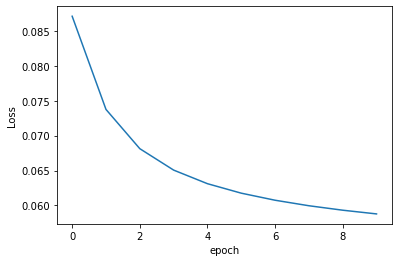

In [75]:

plt.plot(range(args.num_epochs), tr_loss)
plt.ylabel('Loss')
plt.xlabel('epoch')

#traning plot
plt.plot(t_loss)
plt.ylabel('Loss')
plt.xlabel('epoch')

**Question:** 

Is the decision boundary linear or nonlinear in the case of a logistic regression? Explain.

**Answer:**

Type your answer here:



# Classification with Neural Networks

After you implemented "classical" logistic regression, now you will be implementing a neural network with one or more hidden layers.
You will need to choose the number of hidden layers and nodes in a feedforward neural network, activation function, the type of optimizer and its hyperparmeters which will give you the best result. Remember, we don't want to overfit the training data, we want to generalize the solution for new data not seen during training. 

Plot the same graphs as in the previous sections and explain the similarities and differences. 

**Define the Model:**

In [ ]:


class MlpArgs():
    def __init__(self,lr,num_epochs):
        self.lr = lr
        self.num_epochs = num_epochs

class Classifier_net(nn.Module):
    def __init__(self, in_features,hidden_size):
        super(Classifier_net, self).__init__()
        self.linear = torch.nn.Linear(in_features, 1)

    def forward(self, x):
        x = x.float()
        x = F.sigmoid(self.linear(x))
        return x

#infer function
def infer(net, data,criterion):
    net.eval()
    running_loss = 0
    for i in range(len(data[0])):
        x = data[0][i]
        y = data[1][i]
        with torch.no_grad():
            pred = net(x)
            loss = criterion(y, pred).item()
        running_loss += loss
    return running_loss / len(data)

def training_loop(
    args,
    net,
    train,
    validation=None,
    test=None,
    criterion_func=nn.MSELoss,
    optimizer_func=torch.optim.SGD,
):
    """The training runs here.
    args: a class instance that contains the arguments
    net: the network we're training
    tr_loader, val_loader, test_loader: dataloaders for the train, validation and test sets
    criterion: the loss function
    optimizer: the optimizer to be used"""
    criterion = criterion_func()
    print()
    optimizer = optimizer_func(net.parameters(), lr=args.lr)
    tr_loss, val_loss = [None] * args.num_epochs, [None] * args.num_epochs
    test_loss, untrained_test_loss = None, None
    # Note that I moved the inferences to a function because it was too much code duplication to read.
    if test:
        untrained_test_loss = infer(net, test, criterion)
    for epoch in range(args.num_epochs):
        net.train()
        running_tr_loss = 0
        for i in tqdm(range(len(train[0]))):
            x = train[0][i]
            y = train[1][i]
            optimizer.zero_grad()
            pred = net(x)
            loss = criterion(pred.float(), y.float())
            loss.backward()
            optimizer.step()
            running_tr_loss += loss
        tr_loss[epoch] = running_tr_loss.item() / len(train[0])

        if validation:
            val_loss[epoch] = infer(net, validation, criterion)
    if test:
        test_loss = infer(net, test, criterion)

    print(f"Done training for {args.num_epochs} epochs.")
    print(
        f"The MSE is {untrained_test_loss:.2e} before training and {test_loss:.2e} after training."
    )
    print(
        f"The training and validation losses are "
        f"\n\t{tr_loss}, \n\t{val_loss}, \n\tover the training epochs, respectively."
    )
    return tr_loss, val_loss, test_loss, untrained_test_loss


in_features = x_train.shape[1]
net = MlpLogisticClassifier(in_features)
args = MlpArgs(2e-2,15)
tr_loss, val_loss, test_loss, untrained_test_loss  = training_loop(args,
    net,
    train=(x_train,y_train),
    validation=None,
    test=(x_test,y_test),
    criterion_func=nn.MSELoss,#=nn.CrossEntropyLoss
    )
print("end!")



**Training and validation:**

In [ ]:
### START CODE HERE ###


**Visualizing the plots:**

AttributeError: 'MlpArgs' object has no attribute 'epochs'

# Regression with Neural Networks

In this part of the excercise you will need to implement a regression model using neural networks. The model should predict the output of a trigonometric function of two variables. Your data set is based on a meshgrid. Your task is to create a list of points that would correspond to a grid and use it for the input of your neural network. Then, build your neural networks and find the architecture which gives you the best results.
1. Plot the surface from the overall data and compare it to your predicted test sets.
2. Which loss function and validation metric did you choose?
3. Plot the loss and validation metrics vs epoch for the training and test sets.
4. Build a new neural network and try overfitting your training set. Show that you managed to overfit. Explain.

# Packages 

First import all the packages that you will need during this part of assignment.

Feel free to use another libraries if you want to.

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib import cm

**Generate data:**

In [ ]:
np.random.seed(random_num)
x = np.linspace(-5, 5, 30)
y = np.linspace(-5, 5, 30)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx) * np.cos(yy) + 0.1 * np.random.rand(xx.shape[0], xx.shape[1])

**Define the Model:**

In [ ]:
### START CODE HERE ###


**Training and validation:**

In [ ]:
### START CODE HERE ###


**Visualizing the plots:**

In [ ]:
### START CODE HERE ###


### Build a new neural network and try overfitting your training set

**Generate data:**

In [ ]:
np.random.seed(random_num)
x = np.linspace(-5, 5, 30)
y = np.linspace(-5, 5, 30)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx) * np.cos(yy) + 0.1 * np.random.rand(xx.shape[0], xx.shape[1])

**Define the Model:**

In [ ]:
### START CODE HERE ###


**Training and validation:**

In [2]:
### START CODE HERE ###


**Visualizing the plots:**

In [ ]:
### START CODE HERE ###


5. Briefly explain graph's results.

Type your answer here:



6. How does your metric value differs between the training data and the test data and why?


Type your answer here:

